# Predicting binding affinity of SARS-CoV-2 Main Protease ligands in Covid Moonshot project

### Henriette Capel, Yiming Wei

### 2023-01-26

In [234]:
# Load packages
import math
import warnings

import numpy as np
import pandas as pd
import sklearn
import sklearn.linear_model
import sklearn.ensemble
import sklearn.svm
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import plotnine

## Background
### 1.1 SARS-CoV-2 Main Protease

> Insert one figure to introduce $M^{pro}$

Task: predicting binding affinity of $M^{pro}$ ligands using Covid Moonshot data

### 1.2 Extracting features from SMILES strings

> Introduce Lipinski's rule of five, Molecular descriptors, and molecular fingerprints

### 1.3 Binding affinity metric
* Introduce the definition of $IC_{50}$
* Definition: $pIC_{50} = \log_{10}(IC_{50})$, give the rationale of using $pIC_{50}$
* introduce the concept of assays

## Data Exploration

### 2.1 Binding affinity metric

In [17]:
# Import dataset
data_file = 'activity_data.csv'
df_raw = pd.read_csv(data_file)

From the dataset, most compounds have the metric of f_avg_IC50 and r_avg_IC50

In [71]:
def plot_binding_affinity(df):
    f_and_r = np.sum((~np.isnan(df['f_avg_IC50'])& ~np.isnan(df['r_avg_IC50'])))
    f_and_no_r = np.sum((~np.isnan(df['f_avg_IC50'])& np.isnan(df['r_avg_IC50'])))
    no_f_and_r = np.sum((np.isnan(df['f_avg_IC50'])& ~np.isnan(df['r_avg_IC50'])))
    no_f_and_no_r = np.sum((np.isnan(df['f_avg_IC50'])& np.isnan(df['r_avg_IC50'])))
    
    # plot how many data have
    plt.figure()
    labels = ['both','only f_IC50','only r_IC50','None']
    data = [f_and_r,f_and_no_r,no_f_and_r,no_f_and_no_r]
    explode = [0.1,0.1,0.1,0.1]
    plt.pie(data,explode=explode,labels=labels,autopct='%1.1f%%', textprops={'fontsize': 12})
    plt.title('Compounds with binding affinity',fontsize=15)
    
    # plot correlation of f_avg_IC_50, r_avg_IC_50
    # Note: the unit of IC_50 is micro molar
    df['f_avg_pIC50'] = - np.log10(df['f_avg_IC50']) + 6
    df['r_avg_pIC50'] = - np.log10(df['r_avg_IC50']) + 6
    plt.figure()
    plt.scatter(df['r_avg_pIC50'],df['f_avg_pIC50'],s=8)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('r_avg_pIC50',fontsize=15)
    plt.ylabel('f_avg_pIC50',fontsize=15)
    plt.title('Relationship of r_avg_pIC50 & f_avg_pIC50',fontsize=20)
              
    # plot distribution of f_avg_IC_50
    plt.figure()
    plt.hist(df['f_avg_pIC50'],bins=50)
    plt.title('Distribution of f_avg_pIC50',fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('f_avg_pIC50',fontsize=15)
    plt.ylabel('Counts',fontsize=15)
    
    print('binding compounds: ',np.sum(df['f_avg_pIC50']>5.0))
    print('not binding compounds: ',np.sum(df['f_avg_pIC50']<=5.0))
    print('Total number of compounds analysed: ',np.sum(df['f_avg_pIC50']>5.0) + np.sum(df['f_avg_pIC50']<=5.0))
    
    
    
    

binding compounds:  915
not binding compounds:  1011
Total number of compounds analysed:  1926


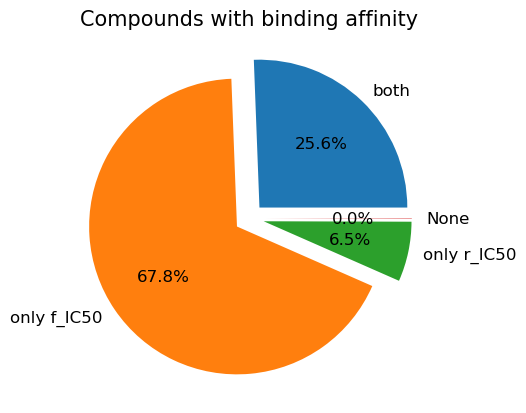

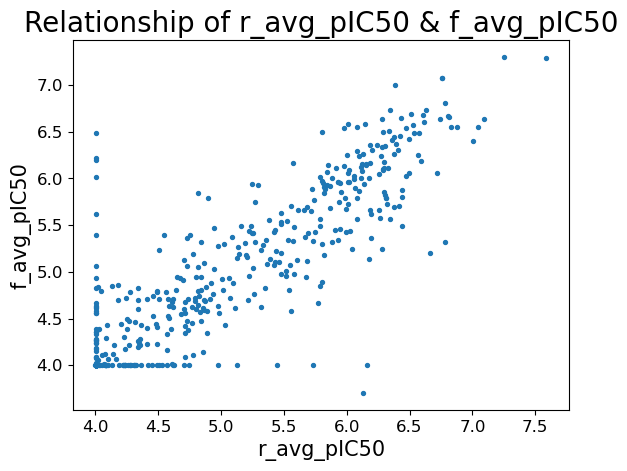

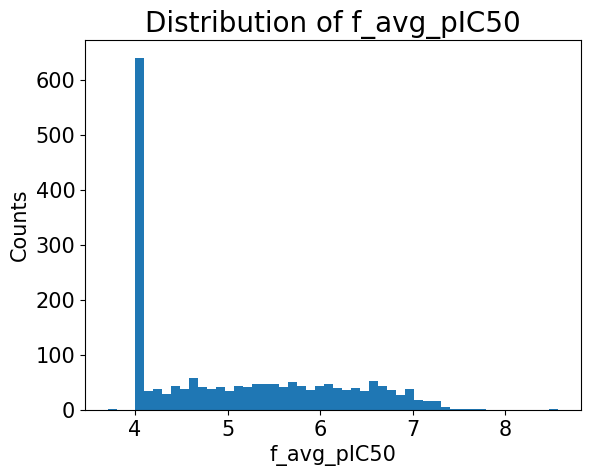

In [72]:
plot_binding_affinity(df_raw)

Summary
* most compounds have f_avg_pIC50 (1926/2062)
* f_avg_pIC50 and r_avg_pIC50 are highly correlated with some expections
* f_avg_pIC50 has a nearly uniform distribution expect at value 4.0

Decision
* Only analyse compounds with f_avg_pIC50
* When doing regression task on f_avg_pIC50, filters out compounds with $pIC_{50}>-\log_{10}(99*10^{-6})$
* When doing classification task on binding or not, use the threshold of $pIC_{50}=5.0$ (915 binding, 1011 not binding)

### 2.2 Molecular descriptors and fingerprints
> explain
> * fingerprint and Chirality
> * Tanimoto index and clustering
> * Highly similar molecules
> * Murcko scaffolds and example

### 2.3 Summary of tasks

* Feature selection: 208 molecular descriptors
* Label:  binding/not binding(classification), f_avg_pIC50 (regression)
* Train/Test data splitting(80/20), fine-tuning hyperparameters with validation data
  1. random splitting
  2. stratified splitting based on fingerprint clusters
* Method
  1. Classification: Logistic Regression, Random Forest, Support Vector Machine
  2. Regression: Linear Regression, Support Vector Regression

## Model Construction

In [235]:
def load_preprocessed_data(task_type,splitting_type):
    if splitting_type == 'random':
        splitting_str = ''
    else:
        splitting_str = '_cluster'
        
    X_train = pd.read_csv('X' + splitting_str + '_train_' + task_type+ '.csv',index_col=0)
    descriptors_set = list(X_train.columns.values)
    
    X_train = X_train.to_numpy()
    X_test = pd.read_csv('X' + splitting_str + '_test_' + task_type+ '.csv',index_col=0).to_numpy()
    y_train = np.load('y' + splitting_str + '_train_' + task_type+ '.npy')
    y_test = np.load('y' + splitting_str + '_test_' + task_type+ '.npy')
    
    
    return X_train, y_train, X_test, y_test, descriptors_set
            

class ClassificationModel():
    def __init__(self,X_train,y_train,X_test,y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def train_and_test(self,model_name, feature_scaling=False,hyperparameter_tuning=False):
        self.feature_scaling = feature_scaling
        if model_name == 'logistic_regression':
            self.model = sklearn.linear_model.LogisticRegression()
            # Compulsory feature scaling
            self.feature_scaling = True
        elif model_name == 'random_forest':
            self.model = sklearn.ensemble.RandomForestClassifier()
        elif model_name == 'SVM':
            self.model = sklearn.svm.SVC()
            self.feature_scaling = True
        else:
            raise ValueError('We have not implemented the method!')
            
        if self.feature_scaling:
            scaler = sklearn.preprocessing.StandardScaler().fit(self.X_train)
            X_train = scaler.transform(self.X_train)
            X_test = scaler.transform(self.X_test)
        else:
            X_train = self.X_train
            X_test = self.X_test
            
        self.model.fit(X_train,self.y_train)
        y_pred = self.model.predict(X_test)
        y_pred_prob = np.squeeze(self.model.predict_proba(self.X_test)[:,1])
        
        accuracy = sklearn.metrics.accuracy_score(self.y_test, y_pred)
        confusion_matrix = sklearn.metrics.confusion_matrix(self.y_test,y_pred)
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(self.y_test, y_pred_prob, pos_label=1)   
        roc_score = sklearn.metrics.roc_auc_score(self.y_test, y_pred_prob)
        
        
        result = {'accuracy':accuracy,
                 'confusion_matrix':confusion_matrix,
                 'fpr': fpr,
                 'tpr':tpr,
                 'thresholds':thresholds,
                 'roc_score':roc_score}
        
        return result
        
    def plot_result(self,result,model_name):
        # Plot confusion matrix
        plt.figure()
        confusion_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=result['confusion_matrix'],display_labels=['not binding','binding'])
        confusion_display.plot()
        plt.title('Confusion_matrix for ' +  model_name)
        
        # Plot roc_curve
        plt.figure()
        if self.feature_scaling: 
            sklearn.metrics.plot_roc_curve(self.model, sklearn.preprocessing.StandardScaler().fit(self.X_train).transform(self.X_test), self.y_test)
        else:
            sklearn.metrics.plot_roc_curve(self.model,self.X_test, self.y_test)
        plt.title('ROC curve for ' +  model_name)
        
            
        
                    
    
    def analyse(self,model_name):
        if model_name == 'random_forest':
            # We analyse the contribution of different features
            importances = self.model.feature_importances_
            std = np.std([tree.feature_importances_ for tree in self.model.estimators_], axis=0)
            forest_importances = pd.Series(importances, index=descriptors_set).sort_values(ascending=False)

            fig, ax = plt.subplots()
            forest_importances.plot.bar(yerr=std, ax=ax)
            ax.set_title("Feature importances using MDI")
            ax.set_ylabel("Mean decrease in impurity")
            fig.tight_layout()
            
        else:
            warnings.warn("Nothing more to analyse in " + model_name)
        pass
    
class RegressionModel():
    def __init__(self,X_train,y_train,X_test,y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def train_and_test(model_name,feature_scaling=False,hyperparameter_tuning=False):
        pass
    
    def analyse(model_name):
        pass

### 3.1 Classification

> Note: Without specifying, we work on random splitting data in section 3.1 and 3.2, and compare the difference of random splitting and stratified splitting in section 3.3

In [236]:
# Load data and construct the model class first
X_train, y_train, X_test, y_test, descriptors_set = load_preprocessed_data(task_type='classification',splitting_type='random')
cmodel = ClassificationModel(X_train,y_train,X_test,y_test)

#### 3.1.1 Logistic Regression
The possibility of classifying sample $X_i$ as positive is
$$
P(Y_i=1|X_i) = \sigma(\beta_0 + \sum_j \beta_j X_{ij})= \frac{1}{1+e^{-(\beta_0 + \sum_j \beta_j X_{ij})}}
$$

where $\beta_k (0 \leq  k \leq 208)$ are coefficients, and $X_{ij} (1\leq j\leq 208)$ are features.

Logistic Regression uses gradient descent to train, and needs feature scaling.

Text(0.5, 1.0, 'Logistic function')

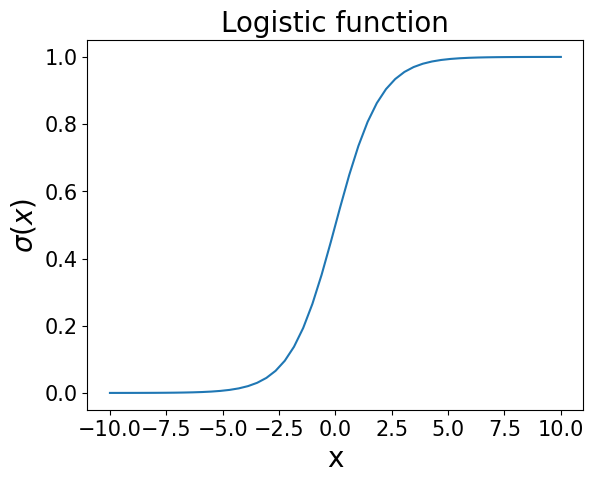

In [237]:
x = np.linspace(-10,10,50)
y = 1 / (1 + np.exp(-x))
plt.plot(x,y)
plt.xlabel('x',fontsize=20)
plt.ylabel(r'$\sigma(x)$',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Logistic function',fontsize=20)

0.7875647668393783


C:\Users\Swimming\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


<Figure size 640x480 with 0 Axes>

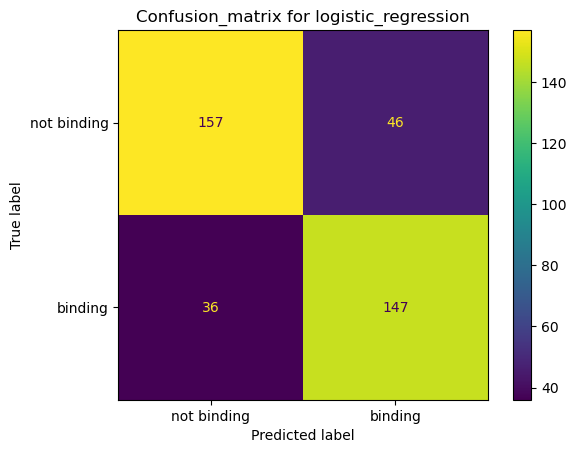

<Figure size 640x480 with 0 Axes>

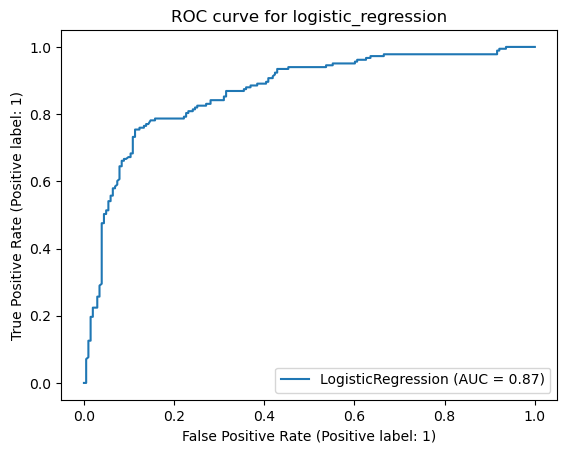

In [238]:
result = cmodel.train_and_test(model_name='logistic_regression')
print(result['accuracy'])
cmodel.plot_result(result,model_name='logistic_regression')

#### 3.2.2 Random Forest Classification

* Decision trees: Use rules of features to reach the final decision (label) in a tree-like structure
* Random Forests: construct multitude decision trees, and use the label which is selected by most trees.

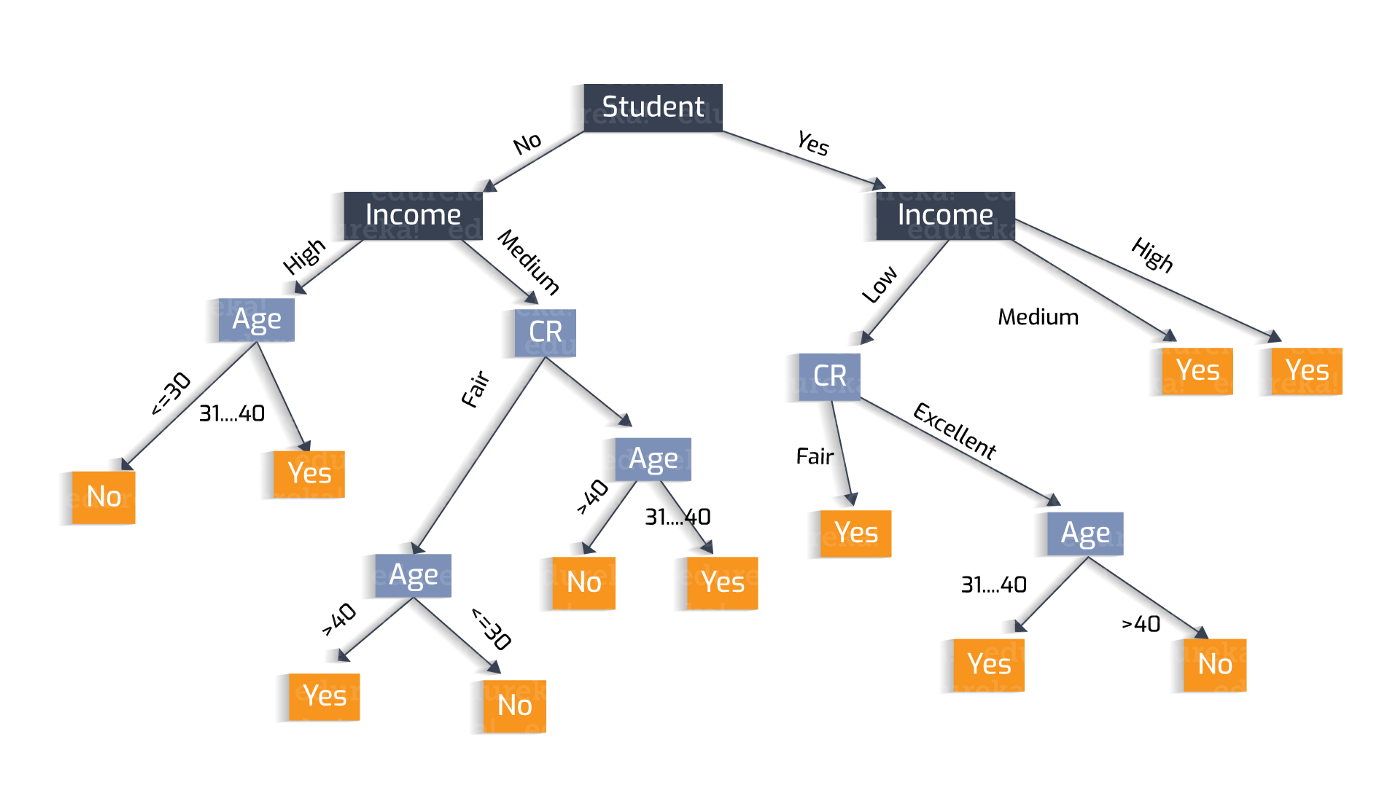

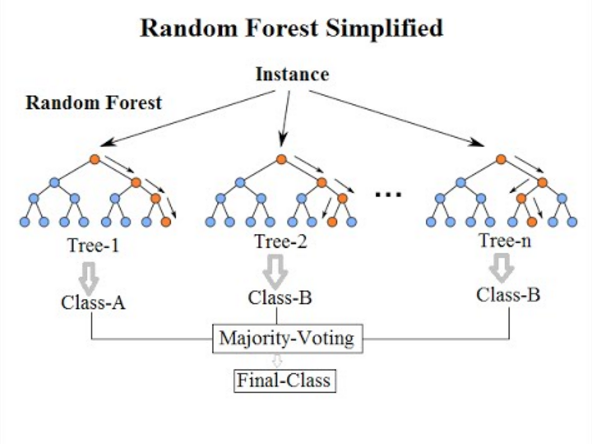

0.8212435233160622


NameError: name 'descriptors_set' is not defined

<Figure size 640x480 with 0 Axes>

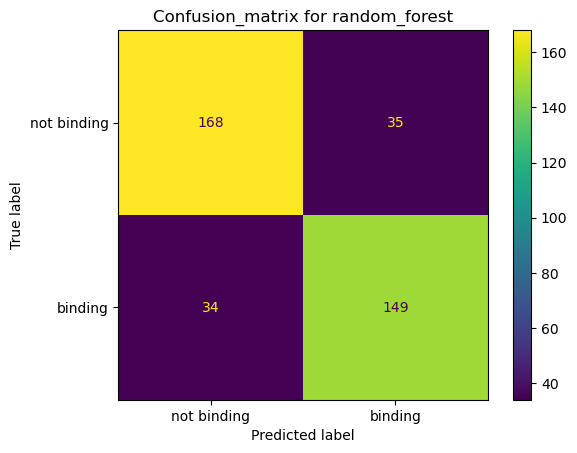

<Figure size 640x480 with 0 Axes>

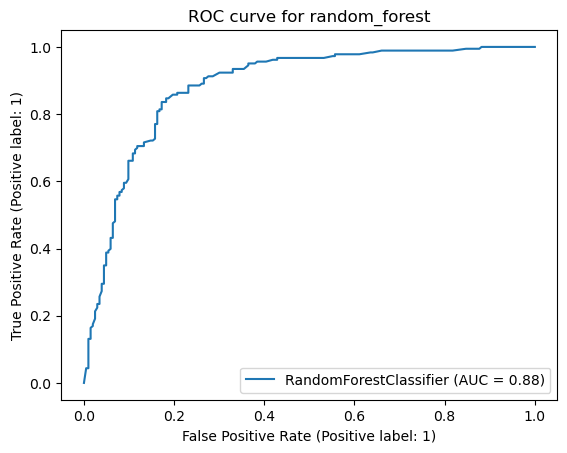

In [241]:
result = cmodel.train_and_test(model_name='random_forest')
print(result['accuracy'])
cmodel.plot_result(result,model_name='random_forest')
cmodel.analyse(model_name='random_forest')

> Note: Using Random Forest, we can work out the relative importance of features.